# Predictive Modeling
### Using Naive Bayes, Decision Tree, Random Forest, and SVM
- **The first step is to import necessary libraries.**

In [114]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# text processing
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob as tb
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models
import scipy.sparse
import pronouncing

# modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC

# doc vector libraries
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim import matutils, models
from gensim.utils import simple_preprocess

# miscellany
import re
import string
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load DataFrame with all genres

In [2]:
# uncomment to load
with gzip.open('data/poetry_all_genres_df_edit.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [3]:
# check genre list
df.genre.unique()

array(['beat', 'black_arts_movement', 'black_mountain', 'confessional',
       'fugitive', 'georgian', 'harlem_renaissance', 'imagist',
       'language_poetry', 'modern', 'new_york_school',
       'new_york_school_2nd_generation', 'objectivist', 'romantic',
       'victorian'], dtype=object)

- **Eliminate two lesser-known genres with dubious reputations.**

In [4]:
# remove poems in the "Fugitive" and "Georgian" genres
df = df[(df.genre != 'fugitive') & (df.genre != 'georgian')]

# reset index
df.reset_index(drop=True, inplace=True)

# check
df.genre.unique()

array(['beat', 'black_arts_movement', 'black_mountain', 'confessional',
       'harlem_renaissance', 'imagist', 'language_poetry', 'modern',
       'new_york_school', 'new_york_school_2nd_generation', 'objectivist',
       'romantic', 'victorian'], dtype=object)

In [6]:
# check out the class imbalance as a percentage
df.genre.value_counts(normalize=True)

modern                            0.292276
victorian                         0.146938
romantic                          0.090951
imagist                           0.081353
new_york_school                   0.060329
black_mountain                    0.058729
language_poetry                   0.043876
new_york_school_2nd_generation    0.043876
confessional                      0.040219
black_arts_movement               0.037706
objectivist                       0.036335
harlem_renaissance                0.033821
beat                              0.033592
Name: genre, dtype: float64

In [7]:
# check out the class imbalance by raw count
df.genre.value_counts()

modern                            1279
victorian                          643
romantic                           398
imagist                            356
new_york_school                    264
black_mountain                     257
language_poetry                    192
new_york_school_2nd_generation     192
confessional                       176
black_arts_movement                165
objectivist                        159
harlem_renaissance                 148
beat                               147
Name: genre, dtype: int64

### Downsampling
- **I've tried this with using 200, 225, and 250 as the maximum number of poem instances, and 250 has yielded the best results thus far.**

In [8]:
# list of genres with more than 250 instances
to_downsample = ['modern', 'victorian', 'romantic', 'imagist', 'new_york_school', 'black_mountain']

# instantiate empty list to house chosen indices
to_index = []

# loop over all genres
for genre in df.genre.unique():
    
    # create list of randomly chosen indices from genres with more than 250 poems
    if genre in to_downsample:
        indices_all = np.where(df.genre == genre)[0]
        indices = np.random.choice(indices_all, size=250, replace=False)
        
    # create list of all indices from genres with fewer than 250 poems
    else:
        indices = np.where(df.genre == genre)[0]
    
    # add indices to list
    to_index.append(indices)

# confirm number of genres
len(to_index)

13

In [9]:
# confirm amounts within each genre
for i in to_index:
    print(len(i))

147
165
250
176
148
250
192
250
250
192
159
250
250


In [10]:
# create single list of all chosen indices
downsampled_indices = [i for index in to_index for i in index]

# check sample size
len(downsampled_indices)

2679

In [12]:
# for comparison
df.shape

(4376, 22)

In [13]:
# create dataframe with only chosen indices
df_downsampled = df.loc[downsampled_indices]

# confirm shape
df_downsampled.shape

(2679, 22)

In [14]:
# check out new class imbalance as raw count
df_downsampled.genre.value_counts()

imagist                           250
victorian                         250
black_mountain                    250
romantic                          250
new_york_school                   250
modern                            250
language_poetry                   192
new_york_school_2nd_generation    192
confessional                      176
black_arts_movement               165
objectivist                       159
harlem_renaissance                148
beat                              147
Name: genre, dtype: int64

In [15]:
# check out new class imbalance as percentage
df_downsampled.genre.value_counts(normalize=True)

imagist                           0.093318
victorian                         0.093318
black_mountain                    0.093318
romantic                          0.093318
new_york_school                   0.093318
modern                            0.093318
language_poetry                   0.071669
new_york_school_2nd_generation    0.071669
confessional                      0.065696
black_arts_movement               0.061590
objectivist                       0.059351
harlem_renaissance                0.055244
beat                              0.054871
Name: genre, dtype: float64

- **Classes are now fairly balanced.**

### Create features and target dataframes

In [16]:
# assign a features dataframe
# NOTE: string_titled and string_cleaned are temporary columns to be used in TfidfVectorizer
X = df_downsampled[['num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 'num_end_rhymes', 
        'avg_syllables_word', 'string_titled', 'string_cleaned']]

# assign a target variable
y = df_downsampled['genre']

### Train-Test Split

In [17]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2009, 8) (2009,)
(670, 8) (670,)


## Baseline model -- tf-idf vectors only

In [18]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec_matrix = vectorizer.fit_transform(X_train.string_cleaned)
X_test_vec_matrix = vectorizer.transform(X_test.string_cleaned)

In [19]:
# turn our tf-idf vectors into a dataframe so we can better view feature importances
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec_matrix, columns=vectorizer.get_feature_names())
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec_matrix, columns=vectorizer.get_feature_names())

In [20]:
%%time

# instantiate the naive bayes classifier
bnb_baseline_vec = BernoulliNB()

# fit it to our training set
bnb_baseline_vec.fit(X_train_vec, y_train)

CPU times: user 2.75 s, sys: 370 ms, total: 3.12 s
Wall time: 3.36 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [21]:
%%time

# predict the new document from the testing dataset
y_train_preds_vec = bnb_baseline_vec.predict(X_train_vec)
y_test_preds_vec = bnb_baseline_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
bnb_baseline_vec_acc_train = accuracy_score(y_train, y_train_preds_vec)
bnb_baseline_vec_f1_train = f1_score(y_train, y_train_preds_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {bnb_baseline_vec_acc_train}')
print(f'F1 score: {bnb_baseline_vec_f1_train}')

# print out accuracy and f1 scores for test set
bnb_baseline_vec_acc_test = accuracy_score(y_test, y_test_preds_vec)
bnb_baseline_vec_f1_test = f1_score(y_test, y_test_preds_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {bnb_baseline_vec_acc_test}')
print(f'F1 score: {bnb_baseline_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_vec))

-----TRAIN-----
Accuracy: 0.4962667994026879
F1 score: 0.46331523989343704

-----TEST-----
Accuracy: 0.24477611940298508
F1 score: 0.1798465170551798

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.67      0.05      0.10        37
           black_arts_movement       0.00      0.00      0.00        41
                black_mountain       0.19      0.76      0.30        62
                  confessional       0.00      0.00      0.00        44
            harlem_renaissance       0.00      0.00      0.00        37
                       imagist       0.26      0.71      0.38        62
               language_poetry       0.00      0.00      0.00        48
                        modern       0.17      0.33      0.23        63
               new_york_school       0.38      0.33      0.36        63
new_york_school_2nd_genera

### Confusion matrix visualization

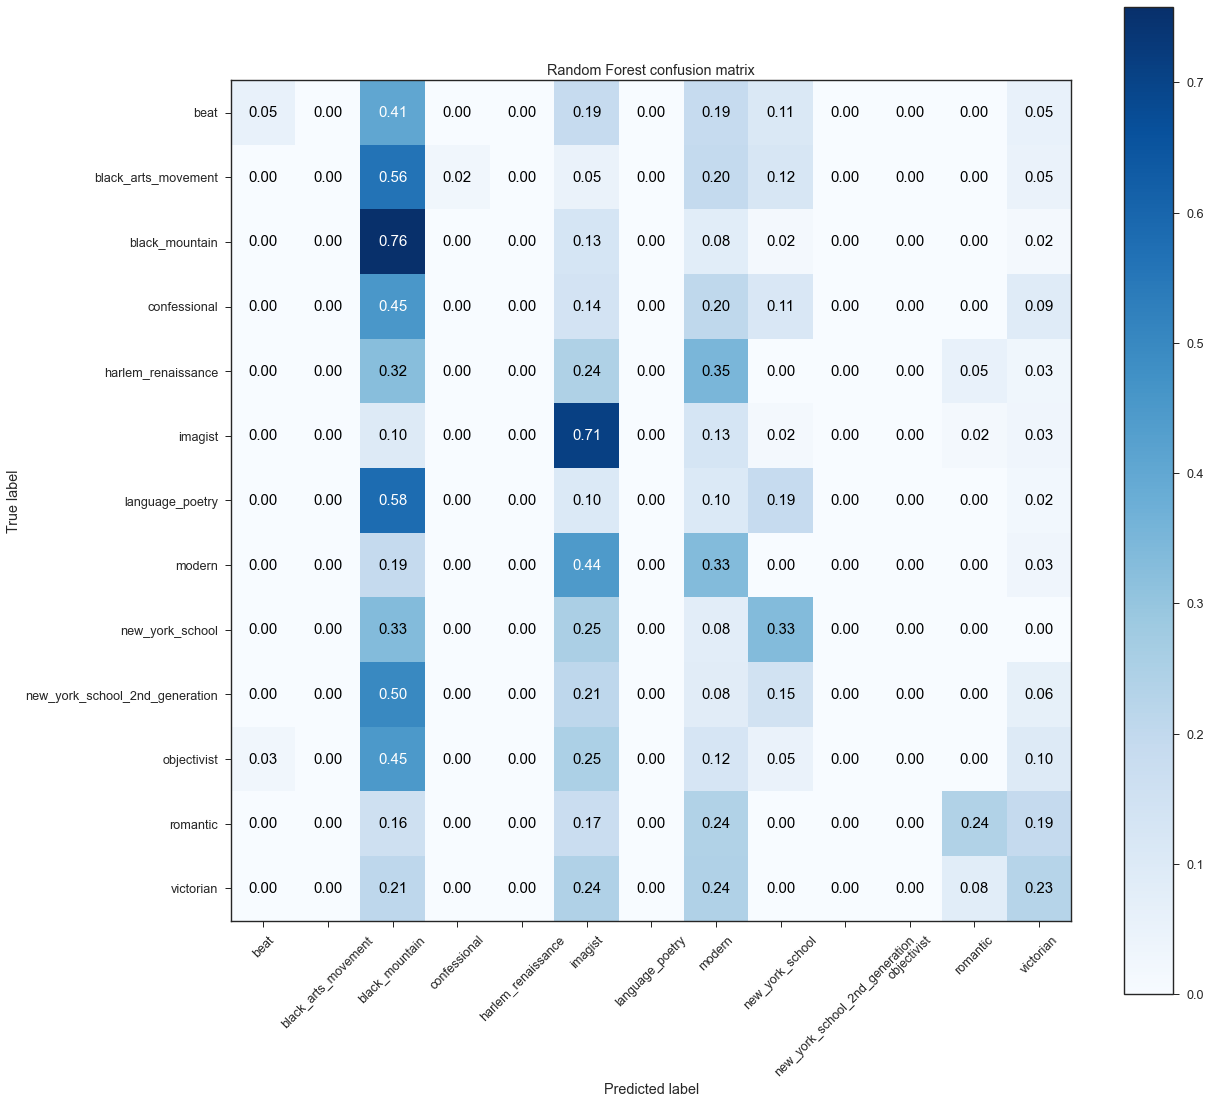

In [115]:
cm = confusion_matrix(y_test, y_test_preds_vec)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Random Forest confusion matrix',
                          cmap=plt.cm.Blues);

- **Certainly better than just picking one of the dominant classes, which would give me roughly 10% accuracy.**
- **That said, it is predicting almost entirely on only the 6 classes with 250 poems.**

## Baseline model -- vectors + numerical data

- **Create dataframe.**

In [24]:
# separate out our numerical data
X_train_nums = X_train.drop(columns=['string_titled', 'string_cleaned'])
X_test_nums = X_test.drop(columns=['string_titled', 'string_cleaned'])

- **Scale and combine.**

In [25]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

In [26]:
# combine the numerical and vector dataframes for both train and test sets
X_train_combo = pd.concat([X_train_scaled_df, X_train_vec], axis=1)
X_test_combo = pd.concat([X_test_scaled_df, X_test_vec], axis=1)

- **Model.**

In [27]:
%%time

# instantiate the naive bayes classifier
bnb_baseline_combo = BernoulliNB()

# fit it to our training set
bnb_baseline_combo.fit(X_train_combo, y_train)

CPU times: user 5.85 s, sys: 945 ms, total: 6.79 s
Wall time: 7.33 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [28]:
%%time

# predict the new document from the testing dataset
y_train_preds_combo = bnb_baseline_combo.predict(X_train_combo)
y_test_preds_combo = bnb_baseline_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
bnb_baseline_combo_acc_train = accuracy_score(y_train, y_train_preds_combo)
bnb_baseline_combo_f1_train = f1_score(y_train, y_train_preds_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {bnb_baseline_combo_acc_train}')
print(f'F1 score: {bnb_baseline_combo_f1_train}')

# print out accuracy and f1 scores for test set
bnb_baseline_combo_acc_test = accuracy_score(y_test, y_test_preds_combo)
bnb_baseline_combo_f1_test = f1_score(y_test, y_test_preds_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {bnb_baseline_combo_acc_test}')
print(f'F1 score: {bnb_baseline_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_combo))

-----TRAIN-----
Accuracy: 0.4962667994026879
F1 score: 0.4625537799358744

-----TEST-----
Accuracy: 0.24776119402985075
F1 score: 0.18259852009100397

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.67      0.05      0.10        37
           black_arts_movement       0.00      0.00      0.00        41
                black_mountain       0.19      0.74      0.30        62
                  confessional       0.00      0.00      0.00        44
            harlem_renaissance       0.00      0.00      0.00        37
                       imagist       0.26      0.69      0.38        62
               language_poetry       0.00      0.00      0.00        48
                        modern       0.19      0.40      0.26        63
               new_york_school       0.38      0.33      0.36        63
new_york_school_2nd_genera

### Confusion matrix visualization

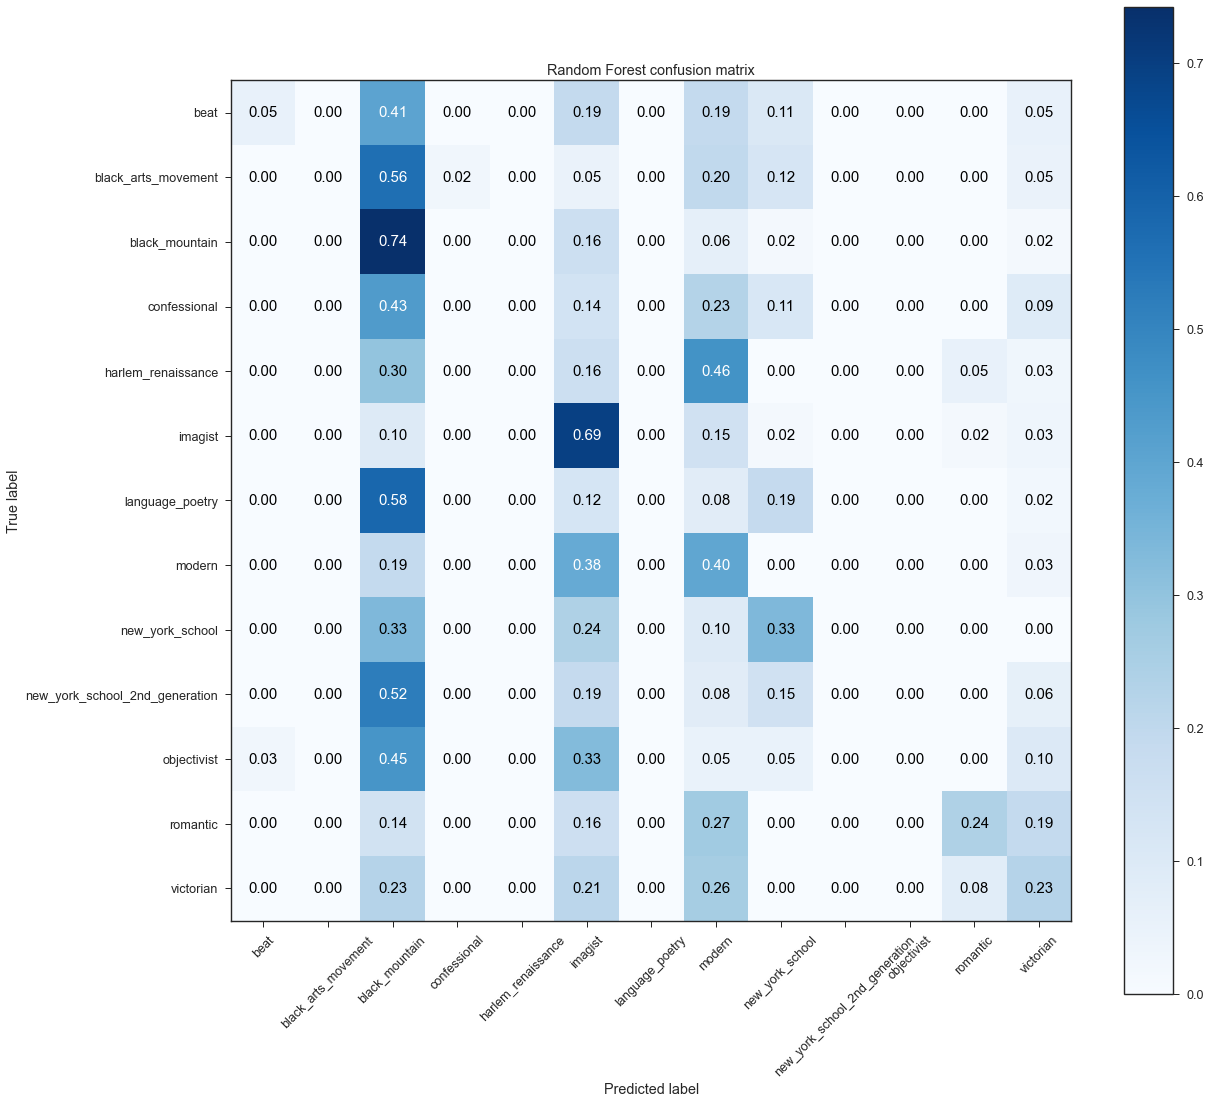

In [117]:
cm = confusion_matrix(y_test, y_test_preds_combo)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Random Forest confusion matrix',
                          cmap=plt.cm.Blues);

- **Very minor improvement, but practically the same result.**

## Decision Tree -- tf-idf vectors only

- **I'll first take a quick look at cross validation scores.**

In [31]:
# instantiate the naive bayes classifier
tree_vec = DecisionTreeClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(tree_vec, X_train_vec, y_train, cv=10, n_jobs=-1)

array([0.1840796 , 0.21890547, 0.19900498, 0.1840796 , 0.19900498,
       0.2238806 , 0.1641791 , 0.19402985, 0.24378109, 0.16      ])

- **Similar to Naive Bayes classifier.**

## Decision Tree -- vectors and numerical data

- **Look at cross validation scores.**

In [32]:
# instantiate the decision classifier
tree_combo = DecisionTreeClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(tree_combo, X_train_combo, y_train, cv=10, n_jobs=-1)

array([0.21393035, 0.21890547, 0.21890547, 0.21890547, 0.21890547,
       0.22885572, 0.21890547, 0.2238806 , 0.19900498, 0.235     ])

- **A small but consistent improvement, so I'll fit a model.**

In [33]:
%%time

# instantiate the model
tree_combo = DecisionTreeClassifier(class_weight='balanced', random_state=1)

# fit to the training set
tree_combo.fit(X_train_combo, y_train)

CPU times: user 4.51 s, sys: 505 ms, total: 5.01 s
Wall time: 5.03 s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [34]:
%%time

# predict class for the train and test sets
y_train_preds_tree_combo = tree_combo.predict(X_train_combo)
y_test_preds_tree_combo = tree_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
tree_combo_acc_train = accuracy_score(y_train, y_train_preds_tree_combo)
tree_combo_f1_train = f1_score(y_train, y_train_preds_tree_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {tree_combo_acc_train}')
print(f'F1 score: {tree_combo_f1_train}')

# print out accuracy and f1 scores for test set
tree_combo_acc_test = accuracy_score(y_test, y_test_preds_tree_combo)
tree_combo_f1_test = f1_score(y_test, y_test_preds_tree_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {tree_combo_acc_test}')
print(f'F1 score: {tree_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_tree_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_tree_combo))

-----TRAIN-----
Accuracy: 0.9995022399203584
F1 score: 0.9995025154102137

-----TEST-----
Accuracy: 0.20298507462686566
F1 score: 0.20196405483667063

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.19      0.16      0.18        37
           black_arts_movement       0.15      0.15      0.15        41
                black_mountain       0.25      0.21      0.23        62
                  confessional       0.13      0.11      0.12        44
            harlem_renaissance       0.12      0.14      0.13        37
                       imagist       0.28      0.29      0.28        62
               language_poetry       0.17      0.21      0.19        48
                        modern       0.06      0.06      0.06        63
               new_york_school       0.20      0.27      0.23        63
new_york_school_2nd_genera

### Confusion matrix visualization

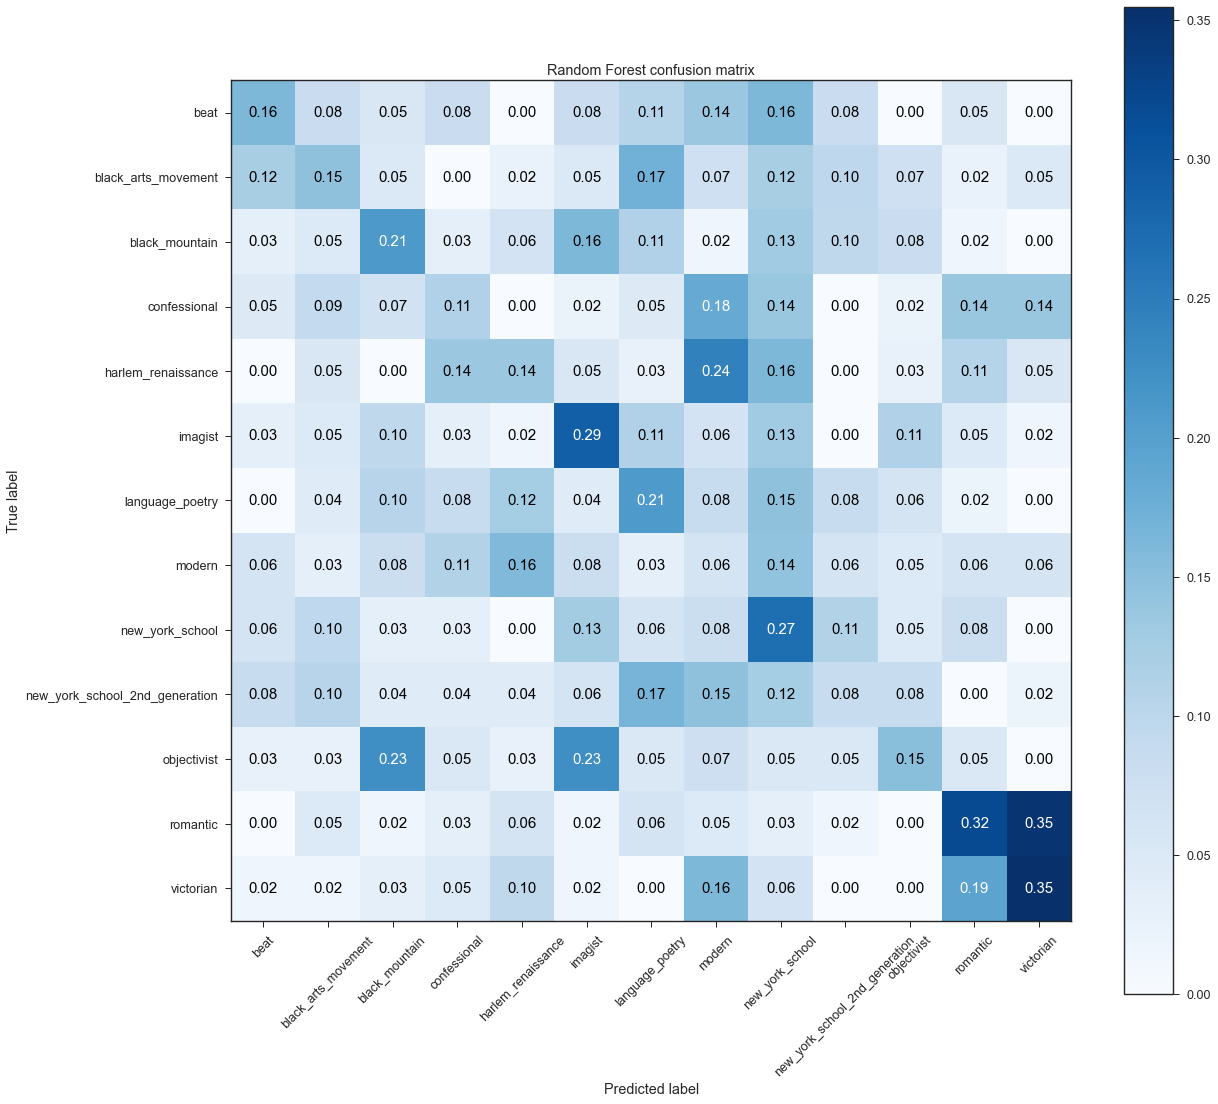

In [118]:
cm = confusion_matrix(y_test, y_test_preds_tree_combo)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Random Forest confusion matrix',
                          cmap=plt.cm.Blues);

- **This is definitely better than our Naive Bayes model.**
    - **It spreads out the predictions a lot more.**
    - **There are some nice clusters between similar genres--looking specifically at the bottom right corner, Romantic and Victorian are often confused with each other which I can live with, since they are so similar to each other.**
    - **Surprisingly, this has trouble predicting Modern, one of the dominant classes.**
    
### Feature importances

In [35]:
# create a dictionary
tree_features = dict(zip(X_train_combo.columns, tree_combo.feature_importances_))

# sort dictionary
tree_features = dict(sorted(tree_features.items(), key=lambda x: x[1], reverse=True)[:10])
tree_features

{'avg_syllables_word': 0.04913425694560059,
 'avg_len_line': 0.04818541238556362,
 'num_end_rhymes': 0.042140281358880725,
 'num_lines': 0.03641225534783489,
 'sentiment_polarity_score': 0.02657047925162978,
 'sentiment_subjectivity_score': 0.025644255336446507,
 'black': 0.012260722915936354,
 'say': 0.011607827450519559,
 'heart': 0.007728179543440106,
 'well': 0.007680186499104526}

- **All of my engineered features are on top.**

## Random Forest -- tf-idf vectors only

- **First, I'll take a quick look at cross validation scores.**

In [36]:
# instantiate the naive bayes classifier
forest_vec = RandomForestClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(forest_vec, X_train_vec, y_train, cv=10, n_jobs=-1)

array([0.31840796, 0.31343284, 0.32835821, 0.25870647, 0.29850746,
       0.33333333, 0.33333333, 0.31840796, 0.34328358, 0.275     ])

- **Compare these to vectors plus numerical data.**

## Random Forest -- vectors and numerical data

- **Take a quick look at cross validation scores.**

In [37]:
# instantiate the decision classifier
forest_combo = RandomForestClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(forest_combo, X_train_combo, y_train, cv=10, n_jobs=-1)

array([0.33333333, 0.31343284, 0.36318408, 0.31840796, 0.32338308,
       0.35820896, 0.36318408, 0.33830846, 0.35820896, 0.35      ])

- **Including engineered features seems more promising, so I'll move ahead with this one.**

In [38]:
%%time

# instantiate the model
forest_combo = RandomForestClassifier(class_weight='balanced', random_state=1)

# fit to the training set
forest_combo.fit(X_train_combo, y_train)

CPU times: user 10.7 s, sys: 606 ms, total: 11.3 s
Wall time: 11.4 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [39]:
%%time

# predict class for the train and test sets
y_train_preds_forest_combo = forest_combo.predict(X_train_combo)
y_test_preds_forest_combo = forest_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
forest_combo_acc_train = accuracy_score(y_train, y_train_preds_forest_combo)
forest_combo_f1_train = f1_score(y_train, y_train_preds_forest_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {forest_combo_acc_train}')
print(f'F1 score: {forest_combo_f1_train}')

# print out accuracy and f1 scores for test set
forest_combo_acc_test = accuracy_score(y_test, y_test_preds_forest_combo)
forest_combo_f1_test = f1_score(y_test, y_test_preds_forest_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {forest_combo_acc_test}')
print(f'F1 score: {forest_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_forest_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_forest_combo))

-----TRAIN-----
Accuracy: 0.9995022399203584
F1 score: 0.9995019537676767

-----TEST-----
Accuracy: 0.3686567164179104
F1 score: 0.3405286317127239

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.67      0.16      0.26        37
           black_arts_movement       0.64      0.22      0.33        41
                black_mountain       0.33      0.60      0.42        62
                  confessional       0.64      0.16      0.25        44
            harlem_renaissance       0.75      0.16      0.27        37
                       imagist       0.31      0.56      0.40        62
               language_poetry       0.33      0.15      0.20        48
                        modern       0.27      0.33      0.30        63
               new_york_school       0.36      0.56      0.44        63
new_york_school_2nd_generati

### Confusion matrix visualization

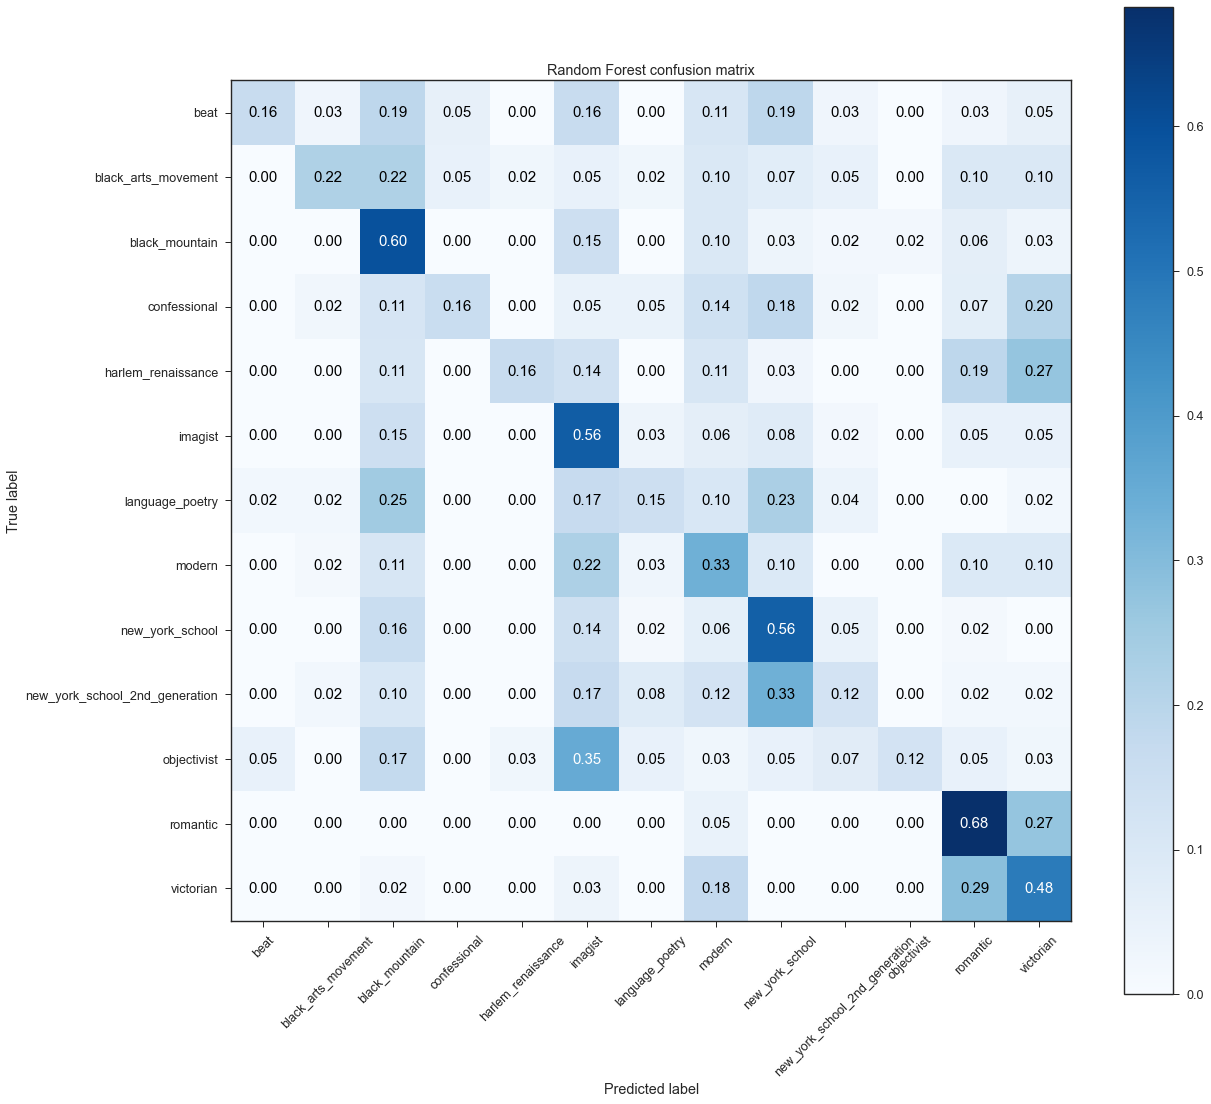

In [40]:
cm = confusion_matrix(y_test, y_test_preds_forest_combo)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Random Forest confusion matrix',
                          cmap=plt.cm.Blues);

- **Big strides made on all categories here.**
- **Still appears to be overpredicting the dominant classes, but fairly precise upon straying from those.**

### Feature importances

In [41]:
# create a dictionary
forest_features = dict(zip(X_train_combo.columns, forest_combo.feature_importances_))

# sort dictionary
forest_features = dict(sorted(forest_features.items(), key=lambda x: x[1], reverse=True)[:10])
forest_features

{'avg_len_line': 0.01130513252420501,
 'num_end_rhymes': 0.009498577650339714,
 'avg_syllables_word': 0.008973569694386223,
 'sentiment_polarity_score': 0.007636833698703033,
 'num_lines': 0.0073097596598570135,
 'sentiment_subjectivity_score': 0.006059996935145201,
 'say': 0.002991765699681059,
 'come': 0.002969502085929477,
 'love': 0.0029518515734059765,
 'one': 0.0028028338932525394}

- **Again, all of my engineered features are on top here, along with some frequent.**

## SVM Model - tf-idf vectors only

In [42]:
%%time

# instantiate the model
svm_vec = SVC(kernel='linear', class_weight='balanced')

# fit to the training set
svm_vec.fit(X_train_vec, y_train)

CPU times: user 4min 46s, sys: 1.34 s, total: 4min 48s
Wall time: 4min 49s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [43]:
%%time

# predict class for the train and test sets
y_train_preds_svm_vec = svm_vec.predict(X_train_vec)
y_test_preds_svm_vec = svm_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
svm_vec_acc_train = accuracy_score(y_train, y_train_preds_svm_vec)
svm_vec_f1_train = f1_score(y_train, y_train_preds_svm_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_vec_acc_train}')
print(f'F1 score: {svm_vec_f1_train}')

# print out accuracy and f1 scores for test set
svm_vec_acc_test = accuracy_score(y_test, y_test_preds_svm_vec)
svm_vec_f1_test = f1_score(y_test, y_test_preds_svm_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_vec_acc_test}')
print(f'F1 score: {svm_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_vec))

-----TRAIN-----
Accuracy: 0.993529118964659
F1 score: 0.9935273424511927

-----TEST-----
Accuracy: 0.4343283582089552
F1 score: 0.43704724578360193

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.55      0.32      0.41        37
           black_arts_movement       0.45      0.34      0.39        41
                black_mountain       0.43      0.52      0.47        62
                  confessional       0.41      0.34      0.37        44
            harlem_renaissance       0.68      0.41      0.51        37
                       imagist       0.41      0.53      0.46        62
               language_poetry       0.37      0.35      0.36        48
                        modern       0.24      0.43      0.31        63
               new_york_school       0.45      0.51      0.48        63
new_york_school_2nd_generati

### Confusion matrix visualization

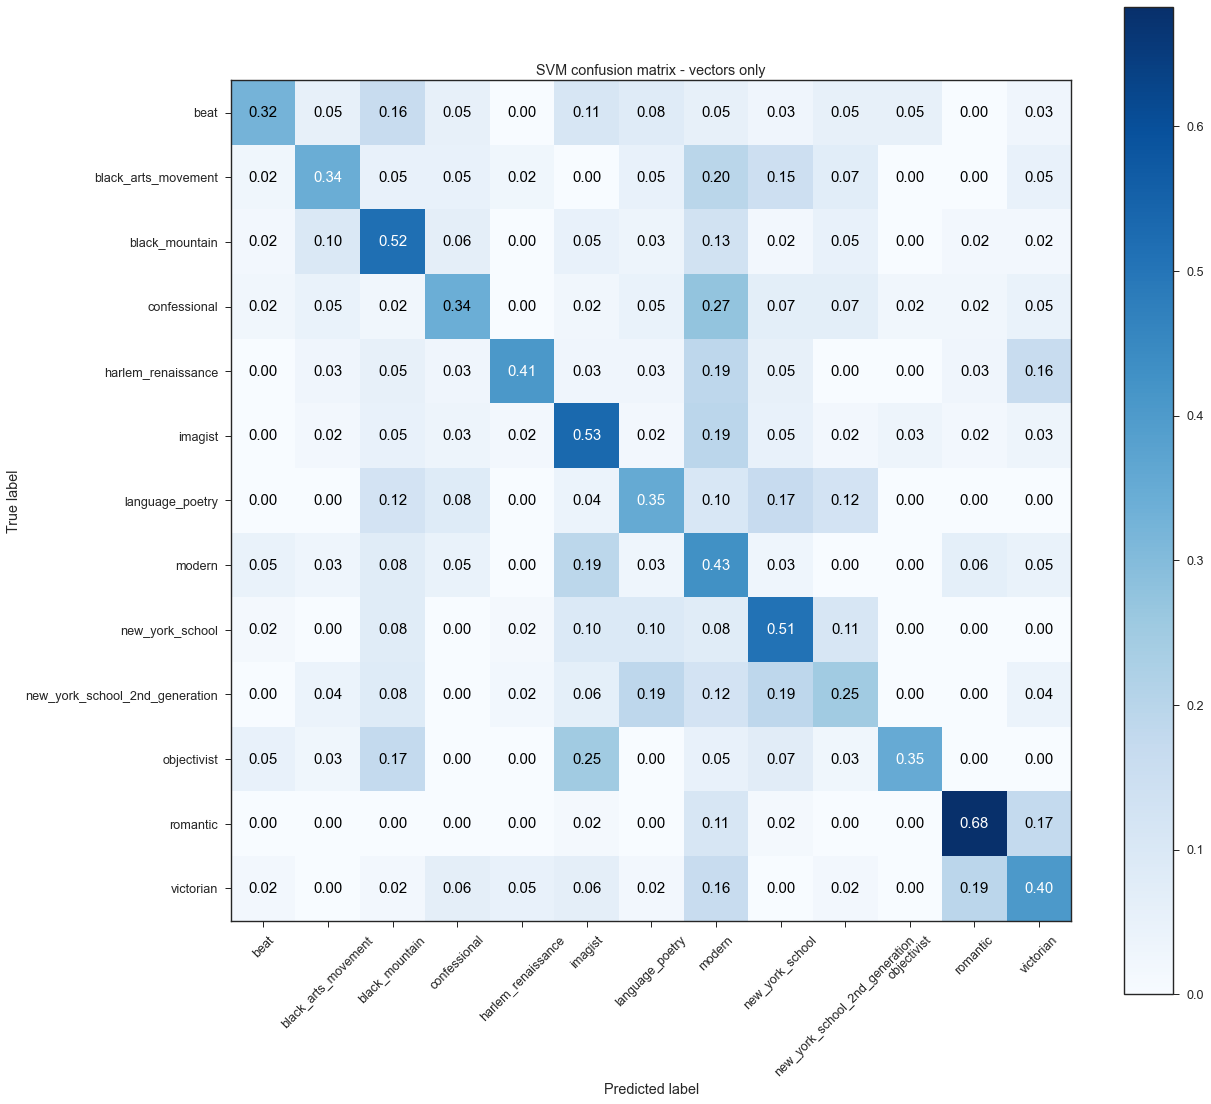

In [44]:
cm = confusion_matrix(y_test, y_test_preds_svm_vec)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix - vectors only',
                          cmap=plt.cm.Blues);

- **Similar but overall better results than the Random Forest.**

### Feature importances

- **Code credit: 'https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn'**

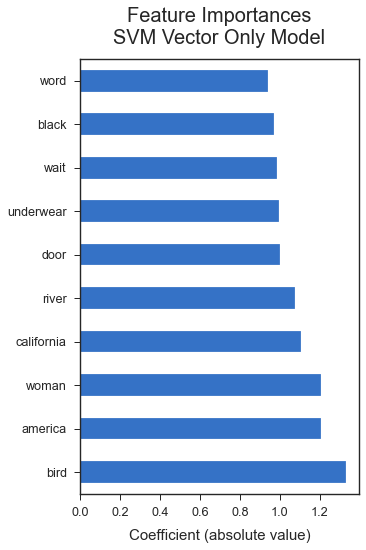

In [45]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Vector Only Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_vec.coef_[0]), index=X_train_vec.columns).nlargest(10).plot(kind='barh');

- **All words here, and mostly interesting ones that aren't in the top 25 most frequent overall.**
- **I'll see if it works any better with my combo dataframes.**

## SVM - vectors + numerical data

In [46]:
%%time

# instantiate the model
svm_combo = SVC(kernel='linear', class_weight='balanced')

# fit to the training set
svm_combo.fit(X_train_combo, y_train)

CPU times: user 4min 26s, sys: 1.74 s, total: 4min 28s
Wall time: 4min 29s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [47]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo = svm_combo.predict(X_train_combo)
y_test_preds_svm_combo = svm_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train = accuracy_score(y_train, y_train_preds_svm_combo)
svm_combo_f1_train = f1_score(y_train, y_train_preds_svm_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train}')
print(f'F1 score: {svm_combo_f1_train}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test = accuracy_score(y_test, y_test_preds_svm_combo)
svm_combo_f1_test = f1_score(y_test, y_test_preds_svm_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test}')
print(f'F1 score: {svm_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo))

-----TRAIN-----
Accuracy: 0.96913887506222
F1 score: 0.9690857202133077

-----TEST-----
Accuracy: 0.4253731343283582
F1 score: 0.42366266594606605

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.46      0.35      0.40        37
           black_arts_movement       0.39      0.27      0.32        41
                black_mountain       0.46      0.58      0.51        62
                  confessional       0.38      0.30      0.33        44
            harlem_renaissance       0.64      0.38      0.47        37
                       imagist       0.45      0.50      0.47        62
               language_poetry       0.31      0.35      0.33        48
                        modern       0.29      0.40      0.34        63
               new_york_school       0.38      0.51      0.43        63
new_york_school_2nd_generatio

### Confusion matrix visualization

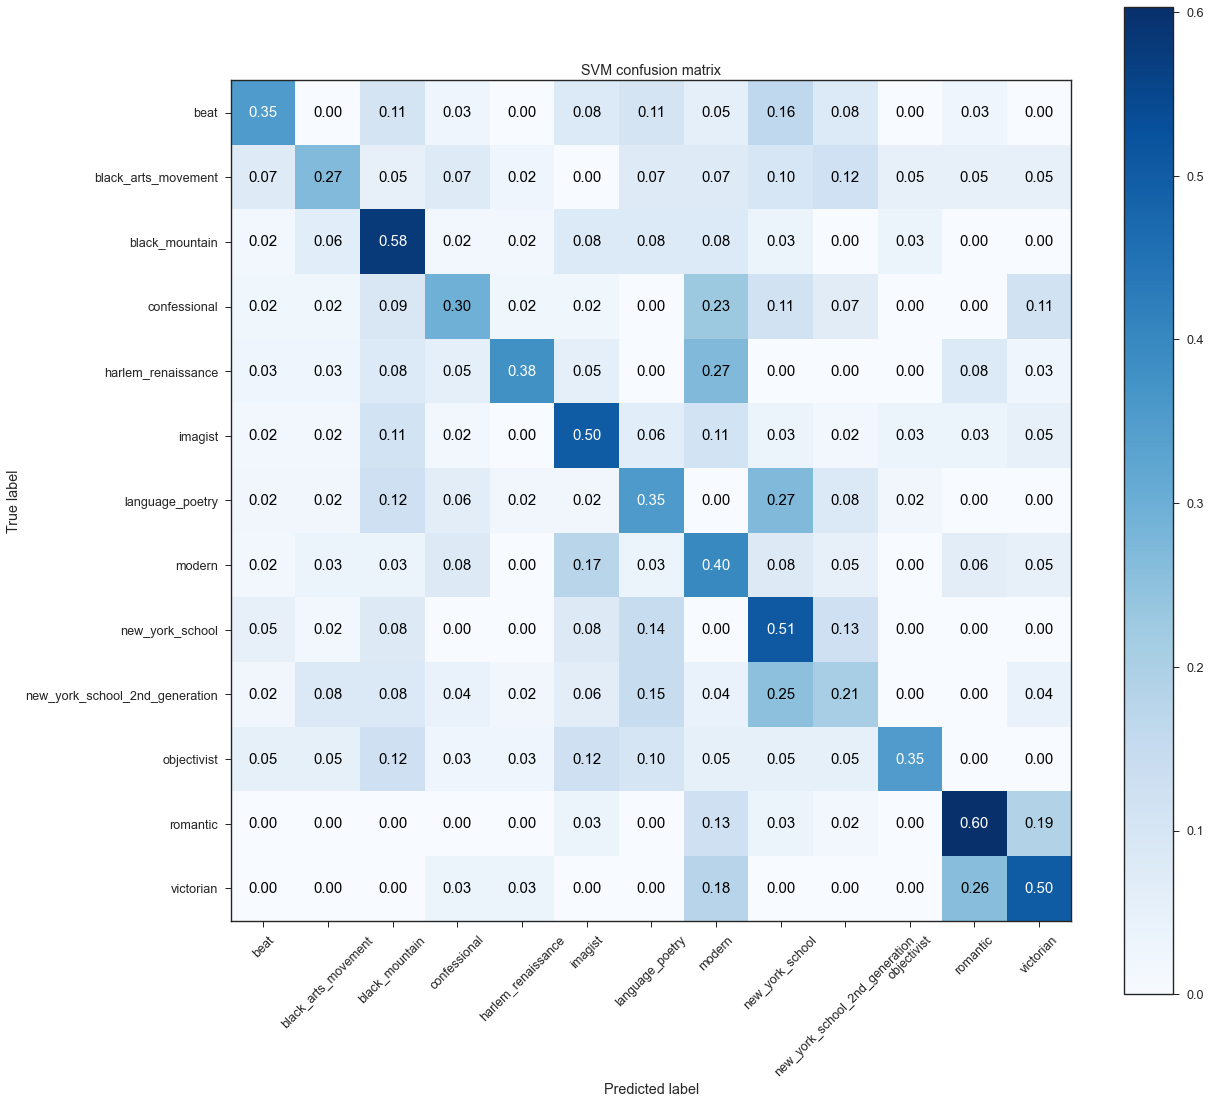

In [48]:
cm = confusion_matrix(y_test, y_test_preds_svm_combo)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

- **Ouch, slightly worse results here.**

### Feature importances

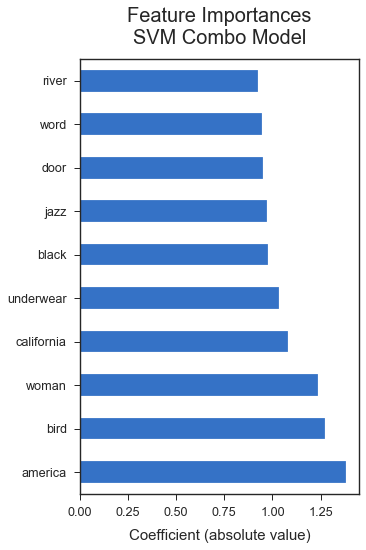

In [49]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo.coef_[0]), index=X_train_combo.columns).nlargest(10).plot(kind='barh');

- **Pretty much the same results for top features.**

# Initial modeling conclusions

- **Form/structure is important for prediction in models other than SVM.**
    - **Further exploration desired:**
        - **Other types of rhyme**
        - **Use of line breaks, tabs, and spacing**
        - **Topic modeling**
- **SVM relies mostly on vocabulary. My engineered features appeared to make prediction worse.**
    - **Further exploration desired:**
        - **Word embeddings (self-trained and pre-trained)**
        - **POS tagging**
- **SVM is the best model!**

# Up next -- introducing document vectors

- **Load the Gensim Doc2Vec model created in the recommendation system notebook (04_recommendation_system.ipynb).**

In [59]:
# load the model
model = Doc2Vec.load('data/doc2vec.model')

In [60]:
# vectors have 100 dimensions
len(model[0])

100

In [165]:
df.columns

Index(['poet_url', 'genre', 'poem_url', 'poet', 'title', 'poem_lines',
       'poem_string', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned', 'doc2vec'],
      dtype='object')

In [168]:
# train-test split
X_train_corpus, X_test_corpus, y_train_corpus, y_test_corpus = train_test_split(df.string_cleaned, df.genre, stratify=df.genre, random_state=42)
print(X_train_corpus.shape, y_train_corpus.shape)
print(X_test_corpus.shape, y_test_corpus.shape)

(3282,) (3282,)
(1094,) (1094,)


In [169]:
# create corpus with the string of every poem (including title)
corpus = X_train_corpus.copy()

In [170]:
# instantiate an empty list
model_corpus = []
# loop over corpus and create tags in the process
for i, line in enumerate(corpus):
    # use Gensim's built-in preprocessing to tokenize strings
    tokens = line.split()
    # convert poems to necessary TaggedDocument format
    model_corpus.append(TaggedDocument(tokens, [i]))

In [171]:
# instantiate the model, setting size of our vectors to 100, only including words that appear at least twice,
# looking at words in the range of five before and five after the current word, setting the learning rate
# and stopping point, and using all cores
model2 = Doc2Vec(vector_size=300, min_count=2, window=5, workers=8, epochs=100)

# build the vocabulary for the model based on the above settings
model2.build_vocab(model_corpus)

In [172]:
model2.train(model_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [177]:
model2.docvecs.index2entity

[]

In [ ]:
df_vecs_train = pd.DataFrame(np.vstack(model2[i] for i in range(len(df))))

### Convert to DataFrame

In [119]:
df_vecs = pd.DataFrame(np.vstack(model[i] for i in range(len(df))))
df_vecs.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,2.281032,-1.371374,-2.219669,-5.061576,0.386490,0.416657,1.340641,-1.559786,-0.314123,-0.465764,...,0.914341,-0.042474,-1.413320,3.378504,-0.387815,-0.327874,-0.029154,1.119749,2.482635,-2.202907
1,2.165715,-2.016965,2.226701,-2.056287,-1.533702,-3.544704,0.543327,1.436396,-3.013705,1.920722,...,-2.519491,-1.564618,2.388425,-3.334627,-2.866033,2.925122,-1.246679,0.222634,-2.713806,-0.705287
2,-0.847129,-3.568497,1.766024,-0.707587,0.187867,-2.000093,3.521604,1.828169,3.784910,1.779436,...,-1.003638,1.122231,3.063076,-0.517507,-0.472288,1.351467,-1.488940,1.042941,0.121341,0.073162
3,-5.168643,-1.855756,1.614694,-3.894295,1.665820,-0.192984,1.739079,-1.540190,3.028075,0.379881,...,-0.311557,-3.424692,0.067995,3.414546,0.398550,-0.784360,-2.558453,3.444434,-1.373973,-2.202393
4,-1.217890,1.304392,-2.843359,-2.121003,3.023178,0.678201,2.796248,2.665455,2.253521,2.352766,...,-0.483795,1.881845,-1.505026,-1.484471,-2.559262,-1.319453,-0.751955,2.392272,-0.071207,-1.690263


In [67]:
# use only the vectors from downsampled dataframe
df_vecs_downsampled = df_vecs.loc[downsampled_indices]

# confirm the shape
df_vecs_downsampled.shape

(2679, 100)

In [68]:
# assign a features dataframe
X2 = pd.concat([df_downsampled[['num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 'num_end_rhymes', 
        'avg_syllables_word']], df_vecs_downsampled], axis=1)
# assign a target variable
y2 = df_downsampled['genre']

In [69]:
# train-test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, stratify=y2, random_state=42)
print(X_train2.shape, y_train2.shape)
print(X_test2.shape, y_test2.shape)

(2009, 106) (2009,)
(670, 106) (670,)


In [70]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our numerical data
X_train_scaled = scaler.fit_transform(X_train2)
X_test_scaled = scaler.transform(X_test2)

In [71]:
%%time

# instantiate the model
svm_doc2vec = SVC(C=1, kernel='linear', class_weight='balanced')

# fit to the training set
svm_doc2vec.fit(X_train_scaled, y_train2)

CPU times: user 471 ms, sys: 1.77 ms, total: 473 ms
Wall time: 472 ms


SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [72]:
%%time

# predict class for the train and test sets
y_train_preds_svm_doc2vec = svm_doc2vec.predict(X_train_scaled)
y_test_preds_svm_doc2vec = svm_doc2vec.predict(X_test_scaled)

# print out accuracy and f1 scores for train set
svm_doc2vec_acc_train = accuracy_score(y_train2, y_train_preds_svm_doc2vec)
svm_doc2vec_f1_train = f1_score(y_train2, y_train_preds_svm_doc2vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_doc2vec_acc_train}')
print(f'F1 score: {svm_doc2vec_f1_train}')

# print out accuracy and f1 scores for test set
svm_doc2vec_acc_test = accuracy_score(y_test2, y_test_preds_svm_doc2vec)
svm_doc2vec_f1_test = f1_score(y_test2, y_test_preds_svm_doc2vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_doc2vec_acc_test}')
print(f'F1 score: {svm_doc2vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test2, y_test_preds_svm_doc2vec, target_names=list(y2.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test2, y_test_preds_svm_doc2vec))

-----TRAIN-----
Accuracy: 0.658038825286212
F1 score: 0.6581874070731841

-----TEST-----
Accuracy: 0.39850746268656717
F1 score: 0.40057597596585487

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.21      0.30      0.24        37
           black_arts_movement       0.25      0.39      0.31        41
                black_mountain       0.45      0.40      0.43        62
                  confessional       0.37      0.43      0.40        44
            harlem_renaissance       0.32      0.43      0.37        37
                       imagist       0.39      0.35      0.37        62
               language_poetry       0.30      0.35      0.32        48
                        modern       0.33      0.29      0.31        63
               new_york_school       0.50      0.37      0.42        63
new_york_school_2nd_generat

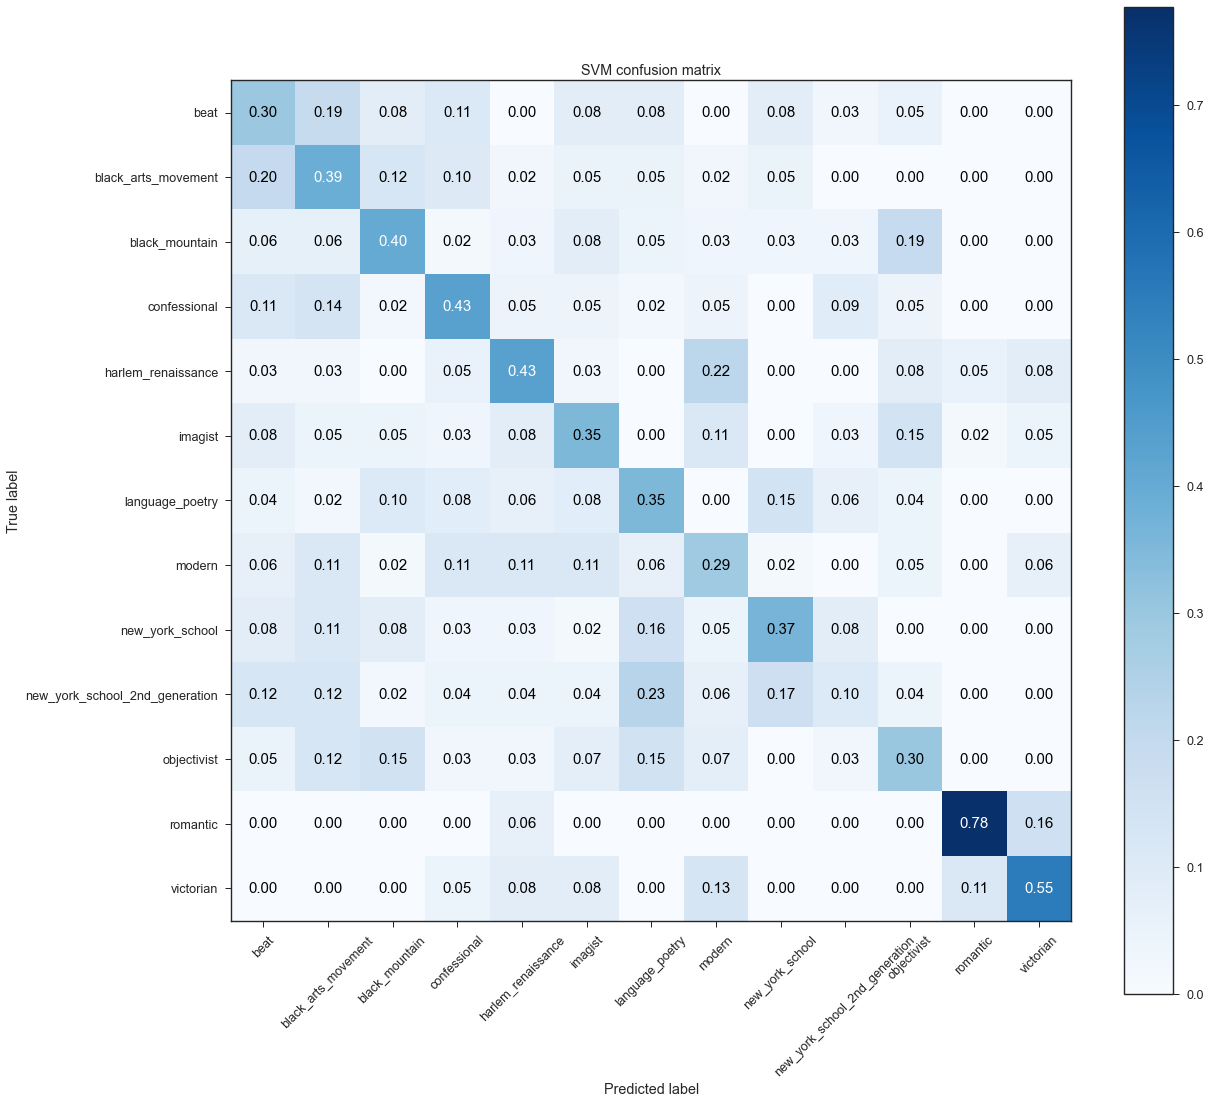

In [73]:
cm = confusion_matrix(y_test, y_test_preds_svm_doc2vec)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

In [120]:
# assign a features dataframe
X3 = pd.concat([df_downsampled[['num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 'num_end_rhymes', 
        'avg_syllables_word', 'string_cleaned']], df_vecs_downsampled], axis=1)
# assign a target variable
y3 = df_downsampled['genre']

In [154]:
# train-test split
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, test_size=0.3, stratify=y3, random_state=42)
print(X_train3.shape, y_train3.shape)
print(X_test3.shape, y_test3.shape)

(1875, 107) (1875,)
(804, 107) (804,)


In [155]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec_matrix = vectorizer.fit_transform(X_train3.string_cleaned)
X_test_vec_matrix = vectorizer.transform(X_test3.string_cleaned)

In [156]:
# turn our tf-idf vectors into a dataframe so we can better view feature importances
X_train_word_vecs = pd.DataFrame.sparse.from_spmatrix(X_train_vec_matrix, columns=vectorizer.get_feature_names())
X_test_word_vecs = pd.DataFrame.sparse.from_spmatrix(X_test_vec_matrix, columns=vectorizer.get_feature_names())

In [157]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our numerical data
X_train_scaled = scaler.fit_transform(X_train3.drop(columns='string_cleaned'))
X_test_scaled = scaler.transform(X_test3.drop(columns='string_cleaned'))

In [158]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train3.drop(columns='string_cleaned').columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test3.drop(columns='string_cleaned').columns)

In [159]:
X_train_scaled_combo = pd.concat([X_train_scaled_df, X_train_word_vecs], axis=1)
X_test_scaled_combo = pd.concat([X_test_scaled_df, X_test_word_vecs], axis=1)

X_train_scaled_combo.shape, X_test_scaled_combo.shape

((1875, 22613), (804, 22613))

In [160]:
%%time

# instantiate the model
svm_doc2vec = SVC(C=1, kernel='linear', class_weight='balanced')

# fit to the training set
svm_doc2vec.fit(X_train_scaled_combo, y_train3)

CPU times: user 3min 5s, sys: 1.44 s, total: 3min 7s
Wall time: 3min 8s


SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [161]:
%%time

# predict class for the train and test sets
y_train_preds_svm_doc2vec = svm_doc2vec.predict(X_train_scaled_combo)
y_test_preds_svm_doc2vec = svm_doc2vec.predict(X_test_scaled_combo)

# print out accuracy and f1 scores for train set
svm_doc2vec_acc_train = accuracy_score(y_train3, y_train_preds_svm_doc2vec)
svm_doc2vec_f1_train = f1_score(y_train3, y_train_preds_svm_doc2vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_doc2vec_acc_train}')
print(f'F1 score: {svm_doc2vec_f1_train}')

# print out accuracy and f1 scores for test set
svm_doc2vec_acc_test = accuracy_score(y_test3, y_test_preds_svm_doc2vec)
svm_doc2vec_f1_test = f1_score(y_test3, y_test_preds_svm_doc2vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_doc2vec_acc_test}')
print(f'F1 score: {svm_doc2vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test3, y_test_preds_svm_doc2vec, target_names=list(y3.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test3, y_test_preds_svm_doc2vec))

-----TRAIN-----
Accuracy: 0.9765333333333334
F1 score: 0.9764683533147298

-----TEST-----
Accuracy: 0.4614427860696517
F1 score: 0.460922702148535

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.34      0.34      0.34        44
           black_arts_movement       0.33      0.39      0.36        49
                black_mountain       0.44      0.48      0.46        75
                  confessional       0.43      0.40      0.41        53
            harlem_renaissance       0.38      0.41      0.40        44
                       imagist       0.43      0.51      0.47        75
               language_poetry       0.36      0.40      0.38        58
                        modern       0.38      0.35      0.36        75
               new_york_school       0.56      0.51      0.53        75
new_york_school_2nd_generatio

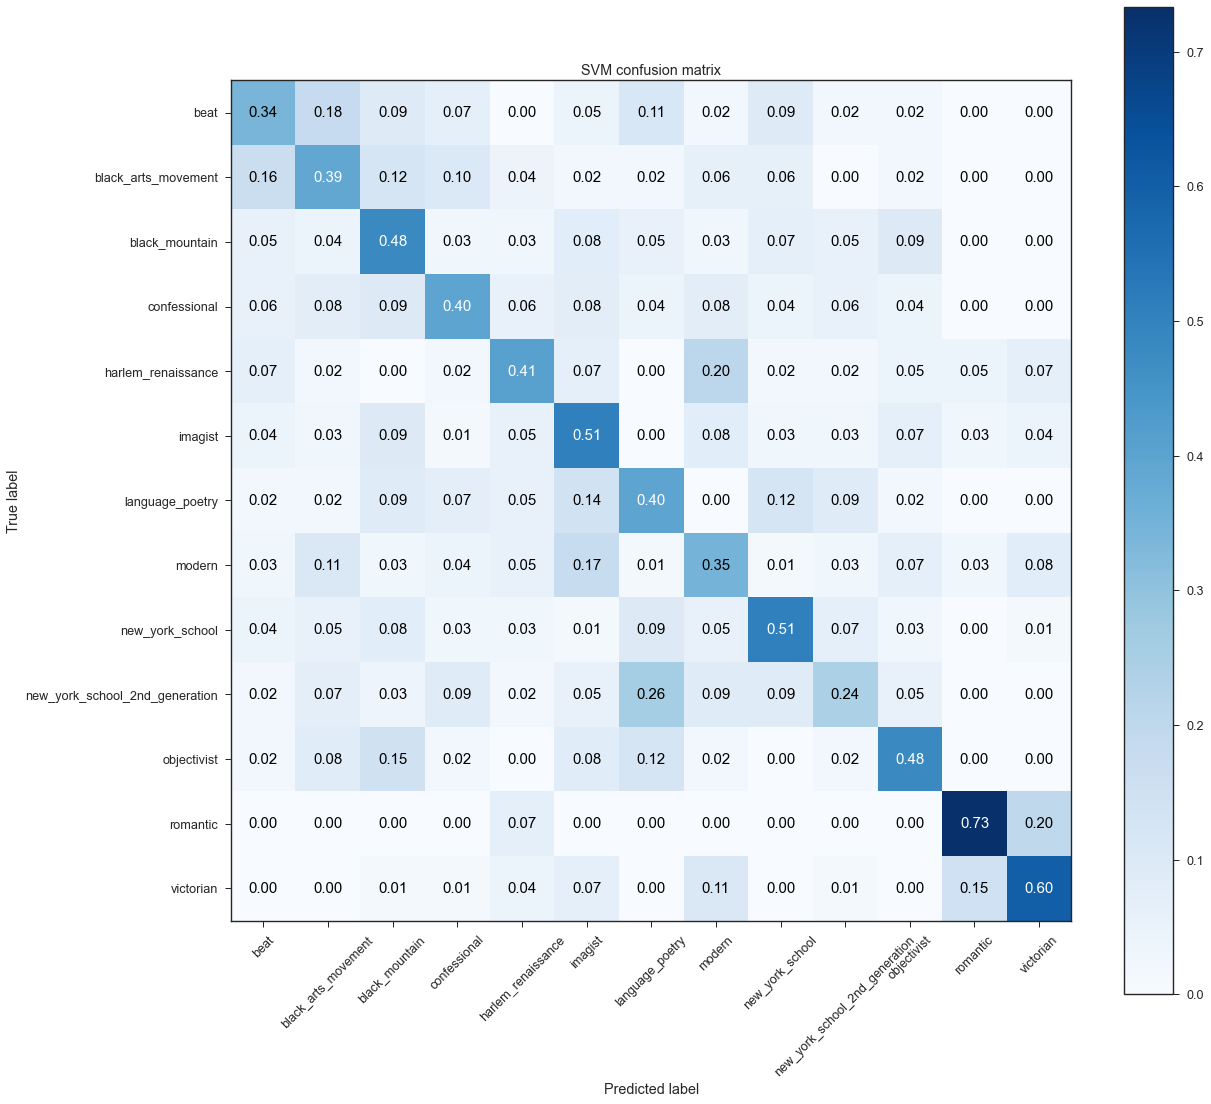

In [162]:
cm = confusion_matrix(y_test3, y_test_preds_svm_doc2vec)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

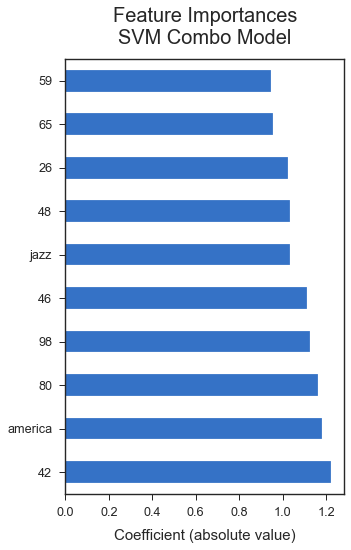

In [163]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_doc2vec.coef_[0]), index=X_train_scaled_combo.columns).nlargest(10).plot(kind='barh');

In [139]:
%%time

# instantiate the model
svm_doc2vec2 = SVC(C=2,
                   kernel='linear',
#                    class_weight='balanced',
                   random_state=42)

# fit to the training set
svm_doc2vec2.fit(X_train_scaled_combo, y_train3)

CPU times: user 3min 43s, sys: 1.57 s, total: 3min 44s
Wall time: 3min 46s


SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [140]:
%%time

# predict class for the train and test sets
y_train_preds_svm_doc2vec2 = svm_doc2vec2.predict(X_train_scaled_combo)
y_test_preds_svm_doc2vec2 = svm_doc2vec2.predict(X_test_scaled_combo)

# print out accuracy and f1 scores for train set
svm_doc2vec_acc_train2 = accuracy_score(y_train3, y_train_preds_svm_doc2vec2)
svm_doc2vec_f1_train2 = f1_score(y_train3, y_train_preds_svm_doc2vec2, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_doc2vec_acc_train2}')
print(f'F1 score: {svm_doc2vec_f1_train2}')

# print out accuracy and f1 scores for test set
svm_doc2vec_acc_test2 = accuracy_score(y_test3, y_test_preds_svm_doc2vec2)
svm_doc2vec_f1_test2 = f1_score(y_test3, y_test_preds_svm_doc2vec2, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_doc2vec_acc_test2}')
print(f'F1 score: {svm_doc2vec_f1_test2}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test3, y_test_preds_svm_doc2vec2, target_names=list(y3.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test3, y_test_preds_svm_doc2vec2))

-----TRAIN-----
Accuracy: 0.9995022399203584
F1 score: 0.9995025154102137

-----TEST-----
Accuracy: 0.45223880597014926
F1 score: 0.44867130846239117

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.26      0.24      0.25        37
           black_arts_movement       0.33      0.37      0.34        41
                black_mountain       0.43      0.52      0.47        62
                  confessional       0.38      0.34      0.36        44
            harlem_renaissance       0.39      0.41      0.40        37
                       imagist       0.44      0.55      0.49        62
               language_poetry       0.36      0.40      0.38        48
                        modern       0.27      0.27      0.27        63
               new_york_school       0.57      0.52      0.55        63
new_york_school_2nd_genera

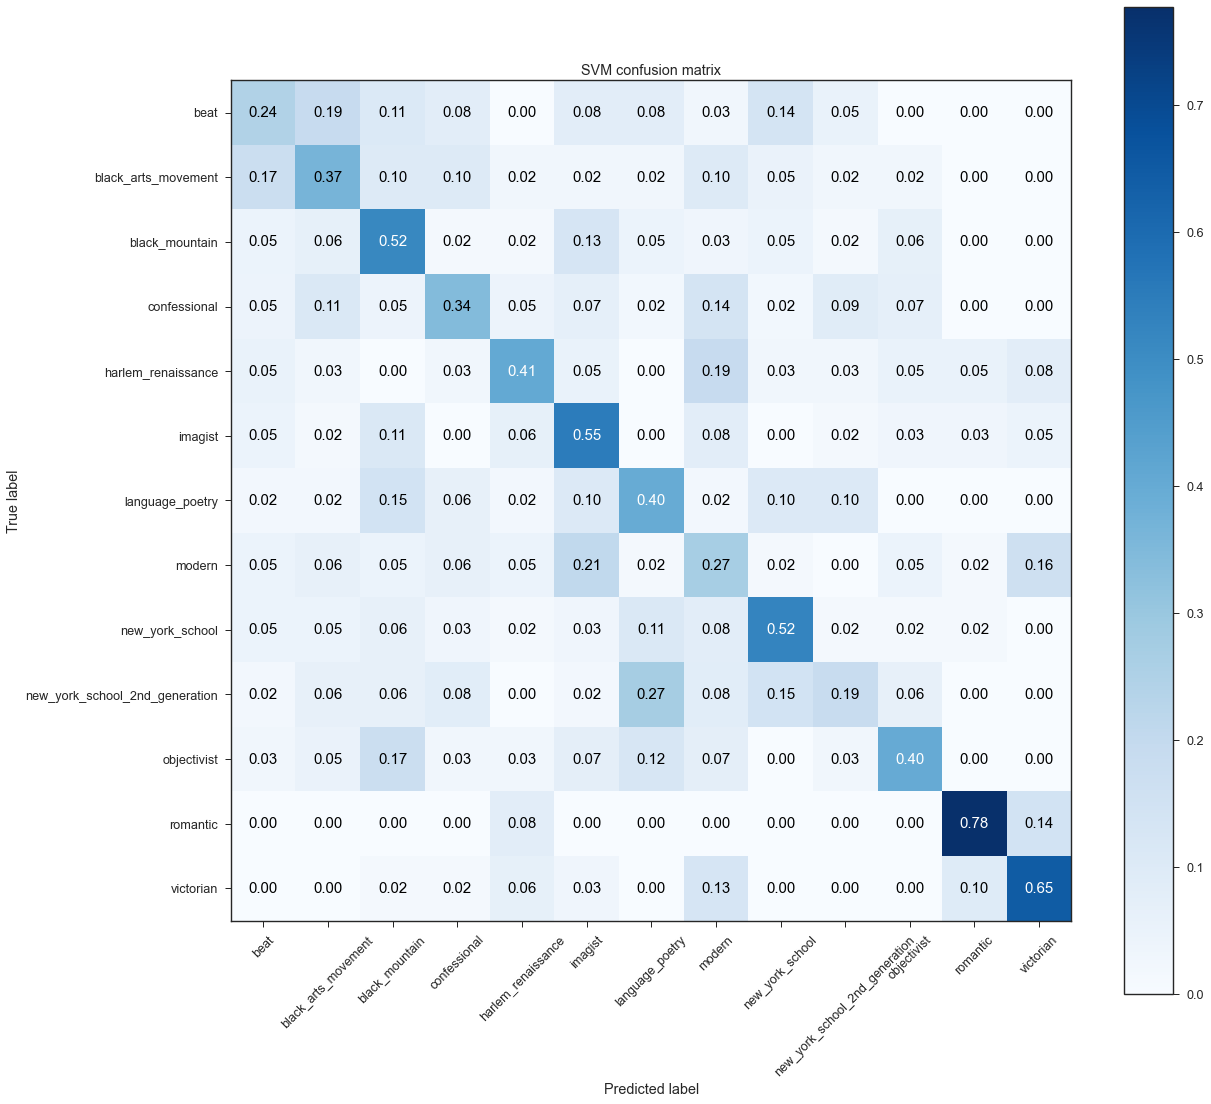

In [141]:
cm = confusion_matrix(y_test, y_test_preds_svm_doc2vec2)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

ValueError: Length of passed values is 23418, index implies 107.

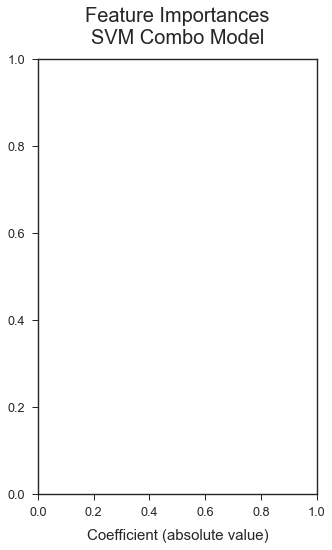

In [142]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_doc2vec2.coef_[0]), index=X_train3.columns).nlargest(10).plot(kind='barh');

In [110]:
%%time

# instantiate the model
svm_doc2vec2b = SVC(C=.01,
                   kernel='linear',
#                    class_weight='balanced',
                   random_state=42)

# fit to the training set
svm_doc2vec2b.fit(X_train_scaled, y_train3)

CPU times: user 5min 23s, sys: 1.26 s, total: 5min 24s
Wall time: 5min 26s


SVC(C=0.01, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [111]:
%%time

# predict class for the train and test sets
y_train_preds_svm_doc2vec2b = svm_doc2vec2b.predict(X_train_scaled)
y_test_preds_svm_doc2vec2b = svm_doc2vec2b.predict(X_test_scaled)

# print out accuracy and f1 scores for train set
svm_doc2vec_acc_train2b = accuracy_score(y_train3, y_train_preds_svm_doc2vec2b)
svm_doc2vec_f1_train2b = f1_score(y_train3, y_train_preds_svm_doc2vec2b, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_doc2vec_acc_train2b}')
print(f'F1 score: {svm_doc2vec_f1_train2b}')

# print out accuracy and f1 scores for test set
svm_doc2vec_acc_test2b = accuracy_score(y_test3, y_test_preds_svm_doc2vec2b)
svm_doc2vec_f1_test2b = f1_score(y_test3, y_test_preds_svm_doc2vec2b, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_doc2vec_acc_test2b}')
print(f'F1 score: {svm_doc2vec_f1_test2b}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test3, y_test_preds_svm_doc2vec2b, target_names=list(y3.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test3, y_test_preds_svm_doc2vec2b))

-----TRAIN-----
Accuracy: 0.47834743653558986
F1 score: 0.38935306403568093

-----TEST-----
Accuracy: 0.3417910447761194
F1 score: 0.2560545726516878

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       1.00      0.03      0.05        37
           black_arts_movement       0.00      0.00      0.00        41
                black_mountain       0.25      0.90      0.39        62
                  confessional       1.00      0.02      0.04        44
            harlem_renaissance       0.00      0.00      0.00        37
                       imagist       0.22      0.82      0.34        62
               language_poetry       0.00      0.00      0.00        48
                        modern       0.08      0.05      0.06        63
               new_york_school       0.53      0.63      0.58        63
new_york_school_2nd_genera

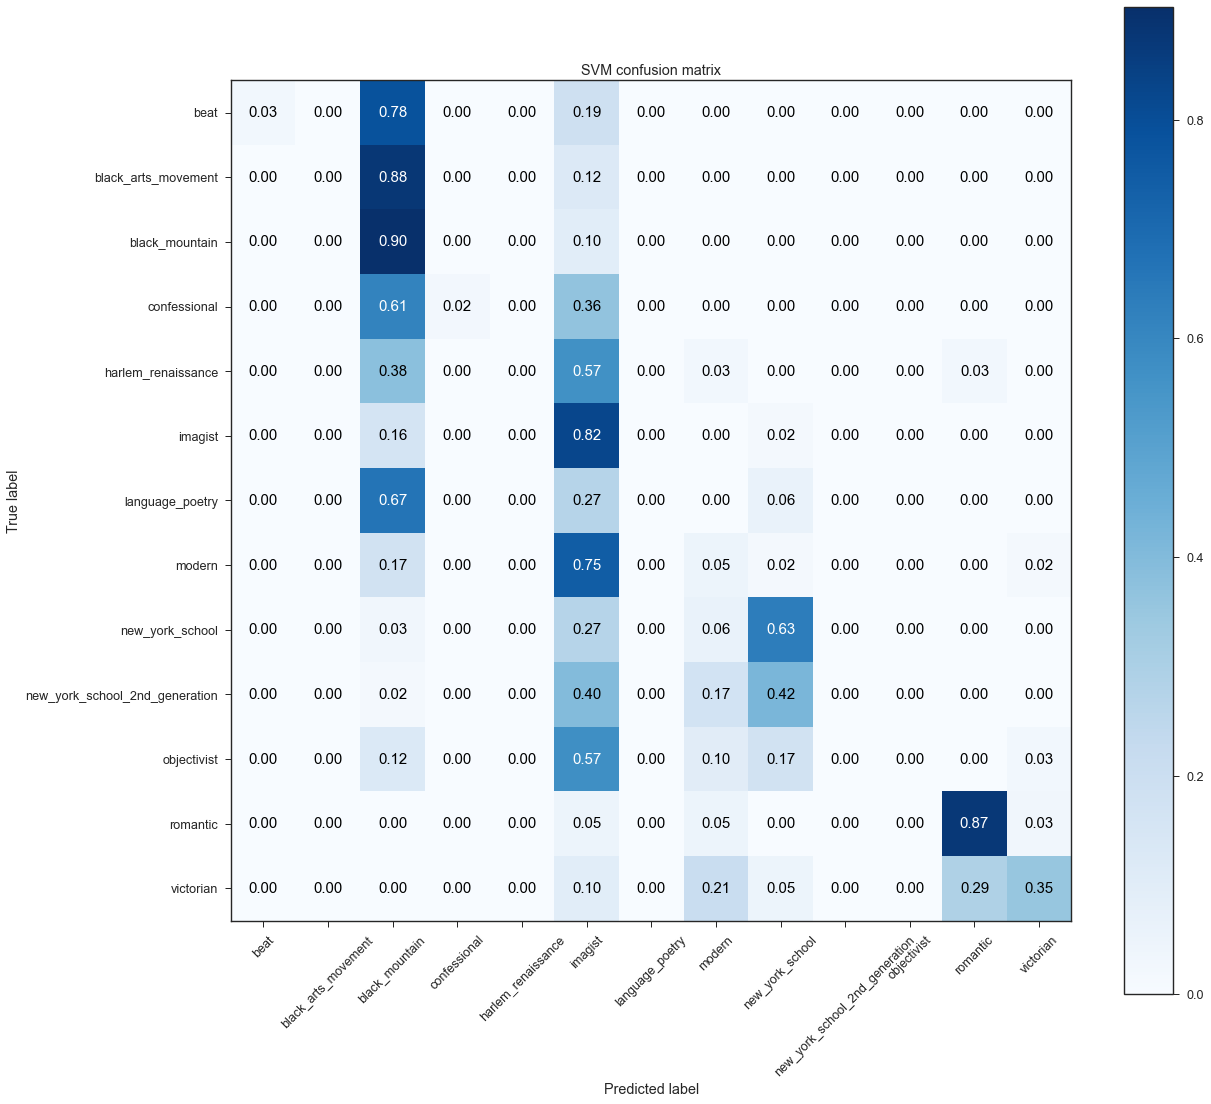

In [112]:
cm = confusion_matrix(y_test, y_test_preds_svm_doc2vec2b)
classes = y3.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

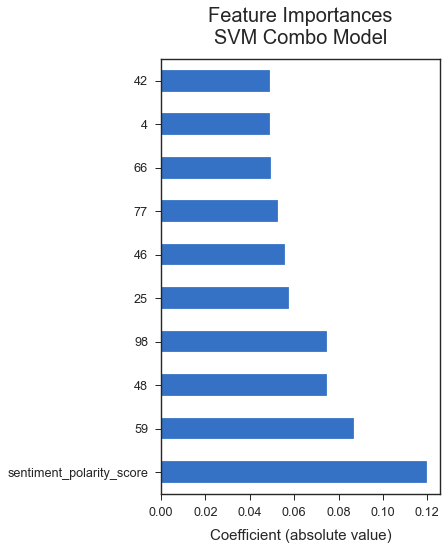

In [113]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_doc2vec2b.coef_[0]), index=X_train3.columns).nlargest(10).plot(kind='barh');